In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Menyiapkan Direktori

In [ ]:
base_dir = '/content/drive/My Drive/FGA/'
!ls '/content/drive/My Drive/FGA/'

bahan  latih  validasi


In [ ]:
# menentukan direktori
bahan_dir = os.path.join(base_dir, "bahan")
train_dir = os.path.join(base_dir, "latih")
validation_dir = os.path.join(base_dir, "validasi")

In [ ]:
# menentukan direktori isi bahan
seratus_dir = os.path.join(bahan_dir, "seratus/")
limapuluh_dir = os.path.join(bahan_dir, "limapuluh/")

print("jumlah Data Train Tiap Kelas")
print("jumlah gambar uang 100.000 : ", len(os.listdir(seratus_dir)))
print("jumlah gambar uang 50.000 : ", len(os.listdir(limapuluh_dir)))

jumlah Data Train Tiap Kelas
jumlah gambar uang 100.000 :  100
jumlah gambar uang 50.000 :  100


In [ ]:
train_seratus = os.path.join(train_dir, "seratus/")
train_limapuluh = os.path.join(train_dir, "limapuluh/")

validation_seratus = os.path.join(validation_dir, "seratus/")
validation_limapuluh = os.path.join(validation_dir, "limapuluh/")

Menyiapkan Dataset

In [20]:
import os
import random
from shutil import copyfile

def train_val_split(source, train, val, train_ratio):
    total_size = len(os.listdir(source))
    train_size = int(train_ratio * total_size)
    val_size = total_size - train_size

    randomized = random.sample(os.listdir(source), total_size)
    train_files = randomized[0:train_size]
    val_files = randomized[train_size:total_size]

    for i in train_files :
        i_file = source + i
        destination = train + i
        copyfile(i_file, destination)

    for i in val_files:
        i_file = source + i
        destination = val + i
        copyfile(i_file, destination)

#jumlah pembagian training dan testing
train_ratio = 0.9

#pembagian training dan validasi
#traning
source_00 = seratus_dir
train_00 = train_seratus
val_00 = validation_seratus
train_val_split(source_00, train_00, val_00, train_ratio)

#validasi
source_01 = limapuluh_dir
train_01 = train_limapuluh
val_01 = validation_limapuluh
train_val_split(source_01, train_01, val_01, train_ratio)

In [22]:
print("jumlah All uang seratus    : ", len(os.listdir(seratus_dir)))
print("jumlah Train uang seratus  : ", len(os.listdir(train_seratus)))
print("jumlah Val uang seratus    : ", len(os.listdir(validation_seratus)))

jumlah All uang seratus    :  100
jumlah Train uang seratus  :  100
jumlah Val uang seratus    :  29


Pre Processing

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    horizontal_flip = True,
    shear_range = 0.3,
    fill_mode = 'nearest',
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.1
)

val_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    horizontal_flip = True,
    shear_range = 0.3,
    fill_mode = 'nearest',
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.1
)

target

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 10,
    class_mode = 'categorical'
)
val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size = (150, 150),
    batch_size = 10,
    class_mode = 'categorical'
)

Found 199 images belonging to 2 classes.
Found 39 images belonging to 2 classes.


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if(logs.get('accuracy') > 0.99):
      print('\nakurasi mencapai 99%')
      self.model.stop_training = True

callbacks = myCallback()

Model CNN

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', input_shape = (150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(200, activation = 'relu'),
    tf.keras.layers.Dropout(0.3, seed = 112),
    tf.keras.layers.Dense(500, activation = 'relu'),
    tf.keras.layers.Dropout(0.5, seed = 112),
    tf.keras.layers.Dense(2, activation = 'sigmoid'),

])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 64)        0

In [ ]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'Adam',
              metrics = ['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = 6,
    epochs = 25,
    validation_data = val_generator,
    validation_steps = 1,
    verbose = 1,
    callbacks = [callbacks]
)

Epoch 1/25
6/6 [==============================] - 14s 2s/step - loss: 0.8451 - accuracy: 0.5333 - val_loss: 0.9914 - val_accuracy: 0.3000
Epoch 2/25
6/6 [==============================] - 10s 2s/step - loss: 0.7156 - accuracy: 0.4576 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 3/25
6/6 [==============================] - 15s 3s/step - loss: 0.6974 - accuracy: 0.4833 - val_loss: 0.6939 - val_accuracy: 0.4000
Epoch 4/25
6/6 [==============================] - 11s 2s/step - loss: 0.6899 - accuracy: 0.5667 - val_loss: 0.6966 - val_accuracy: 0.4000
Epoch 5/25
6/6 [==============================] - 10s 2s/step - loss: 0.7037 - accuracy: 0.5085 - val_loss: 0.6474 - val_accuracy: 0.7000
Epoch 6/25
6/6 [==============================] - 11s 2s/step - loss: 0.6986 - accuracy: 0.5593 - val_loss: 0.6853 - val_accuracy: 0.6000
Epoch 7/25
6/6 [==============================] - 9s 2s/step - loss: 0.6986 - accuracy: 0.5085 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 8/25
6/6 [===================

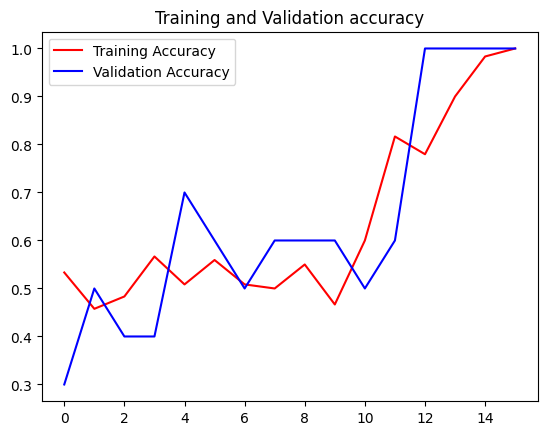

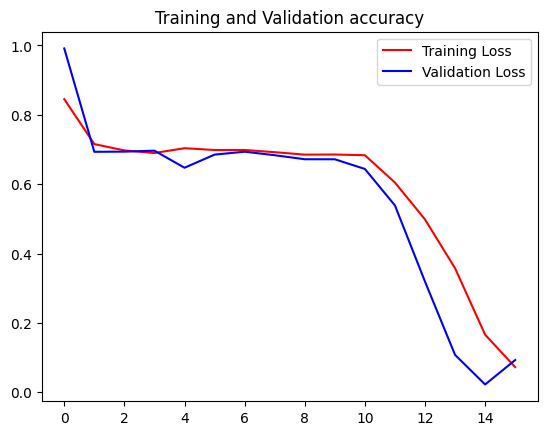

In [ ]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation accuracy')
plt.legend(loc = 'best')
plt.show()

plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and Validation accuracy')
plt.legend(loc = 'best')
plt.show()

Saving 1713177053844.jpg to 1713177053844 (5).jpg
1/1 [==============================] - 0s 38ms/step
1713177053844 (5).jpg
This Image belong to class uang seratus


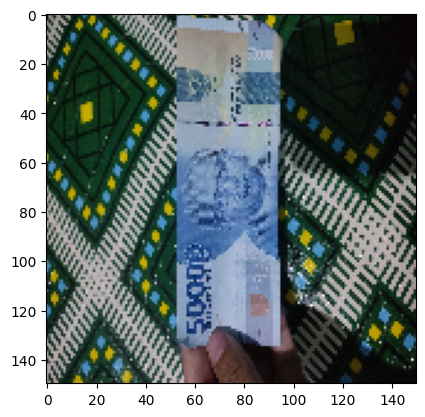

In [24]:
import numpy as np
from keras.preprocessing import image
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():

  #predicting images
  path = fn
  img = image.load_img(path, target_size = (150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size = 100)

  print(fn)

  class_list = os.listdir(train_dir)

for j in range(42):
  if classes[0][j] == 1. :
    print('This Image belong to class uang', class_list[j-1])
    break

Saving 1713177053849.jpg to 1713177053849 (5).jpg
1/1 [==============================] - 0s 36ms/step
1713177053849 (5).jpg
This Image belong to class uang limapuluh


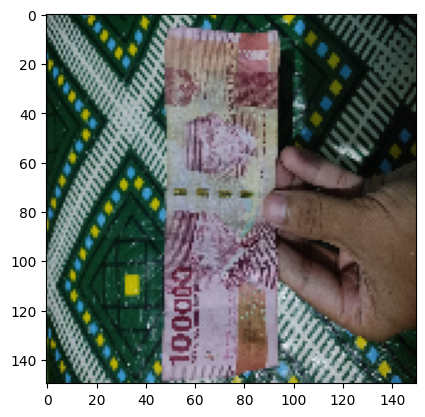

In [25]:
import numpy as np
from keras.preprocessing import image
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():

  #predicting images
  path = fn
  img = image.load_img(path, target_size = (150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size = 100)

  print(fn)

  class_list = os.listdir(train_dir)

for j in range(42):
  if classes[0][j] == 1. :
    print('This Image belong to class uang', class_list[j-1])
    break